In [ ]:
#%pip install -q -r requirements.txt

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


# Принятие решений в бизнесе

## Описание проекта
Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.\
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

## Описание данных
### Данные для первой части
Файл **hypothesis.csv**
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

### Данные для второй части
Файл **orders.csv**
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл **visitors.csv**
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Содержание
- <a id="Загрузка-данных-и-подготовка-их-к-анализу"></a>[1. Загрузка данных и подготовка их к анализу](#1.-Загрузка-данных-и-подготовка-их-к-анализу)
- <a id="Часть 1. Приоритизация-гипотез"></a>[2. Часть 1. Приоритизация гипотез](#2.-Часть-1.-Приоритизация-гипотез)
- <a id="Часть 2. Анализ-A/B-теста"></a>[3. Часть 2. Анализ A/B-теста](#3.-Часть-2.-Анализ-A/B-теста)
- <a id="Выводы"></a>[4. Выводы](#4.-Выводы)

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
pd.set_option('display.max_colwidth', 150)

## 1. Загрузка данных и подготовка их к анализу

Загрузим данные

In [ ]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Посмотрим данные о гипотезах

In [ ]:
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Данные о гипотезах корректны, тип данных соответствующий, пропуски и дубликаты отсутствуют.

Посмотрим данные о заказах

In [ ]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Столбец `date` приведем к формату datetime, проверим отсутствие пропусков и дубликатов

In [ ]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
print('Процент пропусков по столбцам')
print()
round((orders.isna().mean()*100), 2)

Процент пропусков по столбцам



transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

In [ ]:
print('Количество дубликатов:', orders.duplicated().sum())

Количество дубликатов: 0


Проверим таблицу **orders** на пользователей попавших в обе группы

In [ ]:
inter = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
inter

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

Удалим этих пользователей

In [ ]:
orders = orders[~orders['visitorId'].isin(inter)].reset_index()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 6 columns):
index            1016 non-null int64
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null int64
group            1016 non-null object
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 47.8+ KB


Данные о заказах корректны, тип данных соответствующий, пропуски и дубликаты отсутствуют.

Посмотрим данные о количестве пользователей

In [ ]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Столбец `date` приведем к формату datetime, проверим отсутствие пропусков и дубликатов

In [ ]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
print('Процент пропусков по столбцам')
print()
round((visitors.isna().mean()*100), 2)

Процент пропусков по столбцам



date        0.0
group       0.0
visitors    0.0
dtype: float64

In [ ]:
print('Количество дубликатов:', visitors.duplicated().sum())

Количество дубликатов: 0


Данные о количестве пользователей корректны, тип данных соответствующий, пропуски и дубликаты отсутствуют.

<div style="border:solid green 2px; padding: 20px"> 
    
**Комментарий ревьюера**

**#ок**

Данные правильно подготовылены к анализу
</div>

## 2. Часть 1. Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [ ]:
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']).round(1)
display(hypothesis.sort_values('ICE', ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [ ]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
display(hypothesis.sort_values('RICE', ascending=False))

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


- После применения фреймворка RICE, гипотеза 7 переместилась с третьего на первое место, потому что ее параметр Reach равен 10 в то время как у других гипотез он меньше.
- Гипотеза 8 переместилась с первого на пятое место, потому что ее параметр Reach равен 1 в то время как у других гипотез он больше.
- Гипотезы 1, 3, 4 и 5 по прежнему занимают последние четыре места.

## 3. Часть 2. Анализ A/B-теста

Чтобы построить графики, нужно собрать кумулятивные данные.\
Создадим массив уникальных пар значений дат и групп теста

In [ ]:
datesGroups = orders[['date', 'group']].drop_duplicates()

Получим агрегированные кумулятивные по дням данные о заказах

In [ ]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
.agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum'}), axis=1).sort_values(by=['date','group'])

Получим агрегированные кумулятивные по дням данные о посетителях

In [ ]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
                                       .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date','group'])

Объединим кумулятивные данные в одной таблице **cumulativeData**, присвоим ее столбцам названия:
- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [ ]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [ ]:
display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


**cumulativeRevenueA** — датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

In [ ]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]

**cumulativeRevenueB** — датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

In [ ]:
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

Построим графики кумулятивной выручки по группам

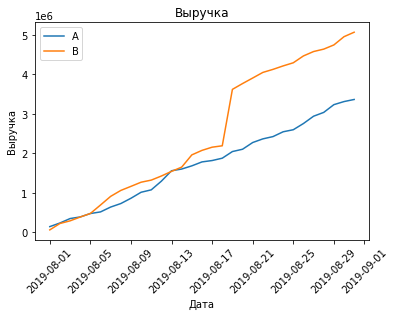

In [ ]:
warnings.filterwarnings('ignore')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Выручка')
plt.legend();

- Выручка почти равномерно увеличивается в течение всего теста. Однако график выручки группы В резко растет в одной точке. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

Построим графики кумулятивного среднего чека по группам

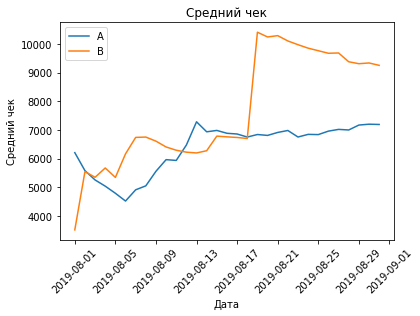

In [ ]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('Средний чек')
plt.legend();

- Средний чек становится равномерным ближе к концу теста. В середине теста имеется резкий всплеск на графике группы В, скорее всего попали крупные заказы. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.                                               

Соберем данные в одном датафрейме **mergedCumulativeRevenue**

In [ ]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

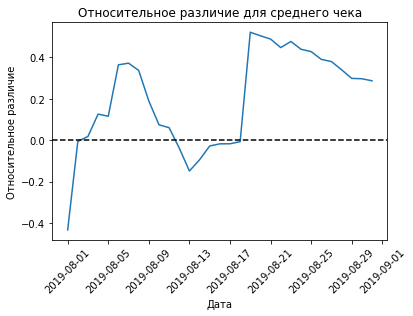

In [ ]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) /
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Относительное различие')
plt.xlabel('Дата')
plt.title('Относительное различие для среднего чека');

- В той же точке имеется сильный всплеск, значит в группу В попали крупные заказы или один заказ.

Посчитаем кумулятивную конверсию, в таблицу **cumulativeData** добавим столбец `conversion`.\
Отделим данные по группе A и по группе B.

In [ ]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

Построим графики кумулятивной конверсии по группам

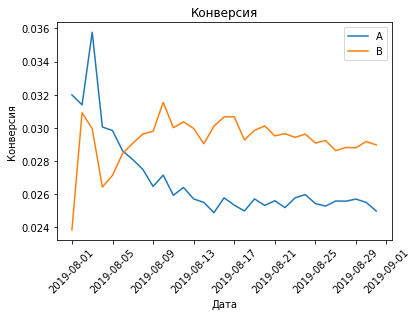

In [ ]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=45)
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('Конверсия')
plt.legend();

- В начале теста графики сильно колебались, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

Соберем данные в одном датафрейме **mergedCumulativeConversions**

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], left_on='date',
                                                                            right_on='date', how='left', suffixes=['A', 'B'])

Построим график относительного изменения кумулятивной конверсии группы B к группе A

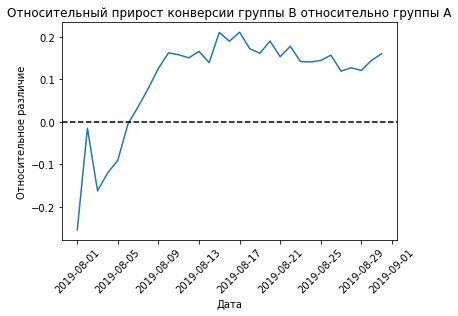

In [ ]:
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] /
         mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Относительное различие')
plt.xlabel('Дата')
plt.title('Относительный прирост конверсии группы B относительно группы A');

- В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд и зафиксировалась примерно на одном уровне с небольшой тенденцией к снижению.

Подсчитаем количество заказов по пользователям и построим точечный график количества заказов по пользователям

In [ ]:
ordersByUsers = (orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsers.columns = ['visitorId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


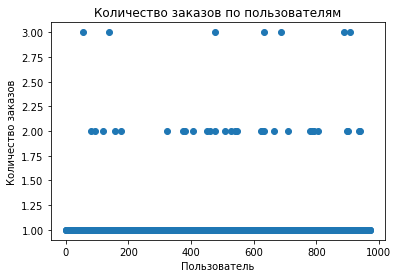

In [ ]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Количество заказов')
plt.xlabel('Пользователь')
plt.title('Количество заказов по пользователям');

- Большинство покупателей заказывали только один раз. Однако доля пользователей с 2 заказами тоже значительна. Их точная доля пока не ясна. Так же имеются пользователи с 3 заказами.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей

In [ ]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


- Не более 1% пользователей оформляли больше чем 2 заказов и не более 5% пользователей заказывали более одного раза.
- Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов — `limit_number_orders`, и отсеять аномальных пользователей по ней.

In [ ]:
limit_number_orders = 2

Построим точечный график стоимостей заказов

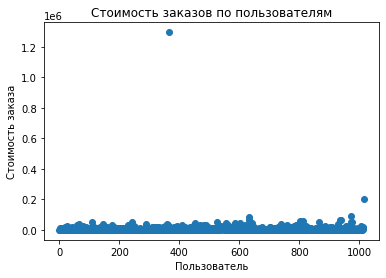

In [ ]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.xlabel('Пользователь')
plt.title('Стоимость заказов по пользователям');

- Есть один очень дорогой заказ, скорее всего он влиял на графиках выручки и среднего чека.

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов

In [ ]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


- Не более 1% заказов дороже 53904 рублей и не более 5% дороже 26785 рублей.
- Разумно выбрать 53904 рублей за нижнюю границу стоимости заказов — limit_cost_orders, и отсеять аномальных пользователей по ней.

In [ ]:
limit_cost_orders = 53904

Для того чтобы посчитать статистическую значимость различий в конверсии и среднем чеке между группами создадим таблицу **data**

In [ ]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1,)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1,)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = (
    ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Описание данных в таблице **data**:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные **ordersByVisitorsA** и **ordersByVisitorsB** со столбцами `visitorId`, `orders`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [ ]:
ordersByVisitorsA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByVisitorsA.columns = ['visitorId', 'orders']

ordersByVisitorsB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByVisitorsB.columns = ['visitorId', 'orders'] 

Объявим переменные **sampleA** и **sampleB**, в которых пользователям из разных групп будет соответствовать количество заказов

In [ ]:
sampleA = pd.concat([ordersByVisitorsA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByVisitorsA['orders'])
                                                                          ), name='orders')],axis=0)

sampleB = pd.concat([ordersByVisitorsB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByVisitorsB['orders'])
                                                                          ), name='orders')],axis=0)

Рассчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.\
Выведем относительный прирост конверсии группы B.\
Сформулируем нулевую и альтернативную гипотезы:
- $H_0$ — различий в конверсии групп A и B нет
- $H_1$ — есть различия в конверсии групп A и B

Критический уровень статистической значимости примем равным 5%\
alpha = 0.05

In [ ]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост конверсии группы B: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.006
Относительный прирост конверсии группы B: 0.160


- P-value меньше 0.05, значит отвергаем нулевую гипотезу.
- По «сырым» данным есть различия в конверсии групп A и B.
- Относительный прирост конверсии группы B составил 16%.

Рассчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным.\
Найдём относительные различия в среднем чеке между группами.\
Сформулируем нулевую и альтернативную гипотезы:
- $H_0$ — различий в среднем чеке групп A и B нет
- $H_1$ — есть различия в среднем чеке групп A и B

Критический уровень статистической значимости примем равным 5%\
alpha = 0.05

In [ ]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))

print('Относительные различия в среднем чеке: {0:.3f}'
      .format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

p-value: 0.415
Относительные различия в среднем чеке: 0.287


- P-value значительно больше 0.05.
- Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет, хотя средний чек группы B значительно выше среднего чека группы A. Скорее всего повлиял выброс со стоимостью заказа свыше 1200000 рублей.
- Необходимо удалить аномальных пользователей и рассчитать показатели по очищеным данным.

Узнаем, сколько всего аномальных пользователей

In [ ]:
usersWithManyOrders = pd.concat(
    [ordersByVisitorsA[ordersByVisitorsA['orders'] > limit_number_orders]['visitorId'],
        ordersByVisitorsB[ordersByVisitorsB['orders'] > limit_number_orders]['visitorId']], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > limit_cost_orders]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print(abnormalUsers.shape)

937    148427295
33     249864742
58     611059232
811    887908475
632    888512513
Name: visitorId, dtype: int64
(16,)


- 16 аномальных пользователей

Объявим переменные **sampleAFiltered** и **sampleBFiltered**, в которых пользователям из разных групп будет соответствовать количество заказов, но без аномальных пользователей

In [ ]:
sampleAFiltered = pd.concat([ordersByVisitorsA[np.logical_not(ordersByVisitorsA['visitorId'].isin(abnormalUsers))]['orders'], pd.Series(0,
            index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByVisitorsA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByVisitorsB[np.logical_not(ordersByVisitorsB['visitorId'].isin(abnormalUsers))]['orders'], pd.Series(0,
            index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByVisitorsB['orders'])), name='orders')], axis=0)

Рассчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.\
Выведем относительный прирост конверсии группы B.

In [ ]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Относительный прирост конверсии группы B: {0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value: 0.004
Относительный прирост конверсии группы B: 0.189


- P-value, по прежнему, меньше 0.05, значит отвергаем нулевую гипотезу.
- Есть различия в конверсии групп A и B.
- Относительный прирост конверсии группы B составил 18,9%.

Рассчитаем статистическую значимость различий в среднем чеке между группами по «очищенным» данным.\
Найдём относительные различия в среднем чеке между группами.

In [ ]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('Относительные различия в среднем чеке: {0:.3f}'.format(orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value: 0.394
Относительные различия в среднем чеке: -0.032


- P-value, по прежнему, значительно больше 0.05.
- Значит нет причин отвергать нулевую гипотезу.
- Относительные различия в среднем чеке составили -3,2%
- Нет статистически значимого различия по среднему чеку между группами

## 4. Выводы

- Есть статистически значимое различие по конверсии между группами по «сырым» и по «очищенным» данным.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: зафиксировались около среднего значения.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по «очищенным» данным;
- График различия среднего чека колеблется: он-то и позволил найти аномалии. Сделать из этого графика определённые выводы нельзя.
- Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Конверсия группы В выше конверсии группы А.